In [2]:
##Posydon V1
from mpi4py import MPI
from posydon.popsyn.binarypopulation import BinaryPopulation
from posydon.binary_evol import SimulationProperties
from posydon.binary_evol.flow_chart import flow_chart
from posydon.binary_evol.MESA.step_mesa import CO_HeMS_step, MS_MS_step, CO_HMS_RLO_step
from posydon.binary_evol.DT.step_detached import detached_step
from posydon.binary_evol.CE.step_CEE import StepCEE
from posydon.binary_evol.SN.step_SN import StepSN
from posydon.binary_evol.DT.double_CO import DoubleCO
from posydon.binary_evol.step_end import step_end
from posydon.binary_evol.simulationproperties import StepNamesHooks

# STEP CUSTOMISATION
MESA_STEP = dict(
    interpolation_path = None, # found by default
    interpolation_filename = None, # found by default
    interpolation_method = 'linear3c_kNN', # 'nearest_neighbour' 'linear3c_kNN' '1NN_1NN'
    save_initial_conditions = True, # only for interpolation_method='nearest_neighbour'
    track_interpolation = False, # True False
    stop_method = 'stop_at_max_time', # 'stop_at_end' 'stop_at_max_time' 'stop_at_condition'
    stop_star = 'star_1', # only for stop_method='stop_at_condition' 'star_1' 'star_2'
    stop_var_name = None, # only for stop_method='stop_at_condition' str
    stop_value = None, # only for stop_method='stop_at_condition' float
    stop_interpolate = True, # True False
    verbose = False, # True False
)

DETACHED_STEP = dict(
    matching_method = 'minimize', #'minimize' 'root'
    do_wind_loss = True, # True False
    do_tides = True,  # True False
    do_gravitational_radiation = True,  # True False
    do_magnetic_braking = True,  # True False
    do_stellar_evolution_and_spin_from_winds = True,  # True False
    RLO_orbit_at_orbit_with_same_am = False,  # True False
    verbose = False,  # True False
)

CE_STEP = dict(
    prescription='alpha-lambda', # 'alpha-lambda'
    common_envelope_efficiency=1.0, # float in (0, inf)
    common_envelope_option_for_lambda='lambda_from_grid_final_values', # (1) 'default_lambda', (2) 'lambda_from_grid_final_values',
                                                  # (3) 'lambda_from_profile_gravitational',
                                                  # (4) 'lambda_from_profile_gravitational_plus_internal',
                                                  # (5) 'lambda_from_profile_gravitational_plus_internal_minus_recombination'
    common_envelope_lambda_default=0.5, # float in (0, inf) used only for option (1)
    common_envelope_option_for_HG_star="optimistic", # 'optimistic', 'pessimistic'
    common_envelope_alpha_thermal=1.0, # float in (0, inf) used only for option for (4), (5)
    core_definition_H_fraction=0.1, # 0.01, 0.1, 0.3
    core_definition_He_fraction=0.1, # 0.1
    CEE_tolerance_err=0.001, # float (0, inf)
    common_envelope_option_after_succ_CEE = 'core_not_replaced_noMT', # 'core_not_replaced_noMT' 'core_replaced_noMT' 'core_not_replaced_stableMT' 'core_not_replaced_windloss'
    verbose = False, # True False
)

SN_STEP = dict(
    mechanism='Patton&Sukhbold20-engine', # 'direct', Fryer+12-rapid', 'Fryer+12-delayed', 'Sukhbold+16-engine', 'Patton&Sukhbold20-engine'
    engine='N20', # 'N20' for 'Sukhbold+16-engine', 'Patton&Sukhbold20-engine' or None for the others
    PISN="Marchant+19", # None, "Marchant+19"
    ECSN="Podsiadlowksi+04", # "Tauris+15", "Podsiadlowksi+04"
    max_neutrino_mass_loss=0.5, # float (0,inf)
    kick=True, # True, False
    kick_normalisation='one_over_mass', # "one_minus_fallback", "one_over_mass", "NS_one_minus_fallback_BH_one", "one", "zero"
    sigma_kick_CCSN_NS=265.0, # float (0,inf)
    sigma_kick_CCSN_BH=265.0, # float (0,inf)
    sigma_kick_ECSN=20.0, # float (0,inf)
    max_NS_mass=2.5,  # float (0,inf)
    use_interp_values=True,  # True, False
    use_profiles=True,  # True, False
    use_core_masses=True,  # True, False
    approx_at_he_depletion=True, # True, False
    verbose = False,  # True False
)

DCO_STEP = dict(
    n_o_steps_interval = None,
)

END_STEP = {}

# FLOW CHART CONFIGURATION
sim_kwargs = dict(
    flow = (flow_chart, {}),
    step_HMS_HMS = (MS_MS_step, MESA_STEP),
    step_CO_HeMS = (CO_HeMS_step, MESA_STEP),
    step_CO_HMS_RLO = (CO_HMS_RLO_step, MESA_STEP),
    step_detached = (detached_step, DETACHED_STEP),
    step_CE = (StepCEE, CE_STEP),
    step_SN = (StepSN, SN_STEP),
    step_dco = (DoubleCO, DCO_STEP),
    step_end = (step_end, END_STEP),
    extra_hooks = [(StepNamesHooks, {})]
)

sim_prop = SimulationProperties(**sim_kwargs)

# SIMULATION CONFIGURATION
kwargs = dict(
    file_path='./batches/',
    optimize_ram=True,
    ram_per_cpu=3., # limit ram usage at 3GB
    dump_rate=10000, # limit batch size

    metallicity = 0.02,
    number_of_binaries=10, # int
    star_formation='burst', # 'constant' 'burst' 'custom_linear' 'custom_log10' 'custom_linear_histogram' 'custom_log10_histogram'
    max_simulation_time=13.8e9, # float (0,inf)

    primary_mass_scheme='Kroupa2001', # 'Salpeter', 'Kroupa1993', 'Kroupa2001'
    primary_mass_min=1, # float (0,130)
    primary_mass_max=25., # float (0,130)
    secondary_mass_scheme='flat_mass_ratio', # 'flat_mass_ratio', 'q=1'
    secondary_mass_min=1, # float (0,130)
    secondary_mass_max=2., # float (0,130)
    orbital_scheme = 'period', # 'separation', 'period'
    orbital_period_scheme = 'Sana+12_period_extended', # used only for orbital_scheme = 'period'
    orbital_period_min = 1., # float (0,inf)
    orbital_period_max = 100., # float (0,inf)
    #orbital_separation_scheme='log_uniform', # used only for orbital_scheme = 'separation', 'log_uniform', 'log_normal'
    #orbital_separation_min=5., # float (0,inf)
    #orbital_separation_max=1e5, # float (0,inf)
    #log_orbital_separation_mean=None, # float (0,inf) used only for orbital_separation_scheme ='log_normal'
    #log_orbital_separation_sigma=None, # float (0,inf) used only for orbital_separation_scheme ='log_normal'
    eccentricity_sche='zero', # 'zero' 'thermal' 'uniform'

    # IMPORT CUSTOM HOOKS
    extra_columns=['step_names'], # 'step_times' with from posydon.binary_evol.simulationproperties import TimingHooks

    # LIST BINARY PROPERTIES TO SAVE
    only_select_columns=[
                        'state',
                        'event',
                        'time',
                        #'separation',
                        'orbital_period',
                        'eccentricity',
                        #'V_sys',
                        #'rl_relative_overflow_1',
                        #'rl_relative_overflow_2',
                        'lg_mtransfer_rate',
                        #'mass_transfer_case',
                        #'trap_radius',
                        #'acc_radius',
                        #'t_sync_rad_1',
                        #'t_sync_conv_1',
                        #'t_sync_rad_2',
                        #'t_sync_conv_2',
                        #'nearest_neighbour_distance',
                        ],

    # LIST STAR PROPERTIES TO SAVE
    include_S1=True , # True, False
    S1_kwargs=dict(only_select_columns=[
                                        'state',
                                        #'metallicity',
                                        'mass',
                                        'log_R',
                                        'log_L',
                                        'lg_mdot',
                                        #'lg_system_mdot',
                                        #'lg_wind_mdot',
                                        'he_core_mass',
                                        'he_core_radius',
                                        #'c_core_mass',
                                        #'c_core_radius',
                                        #'o_core_mass',
                                        #'o_core_radius',
                                        'co_core_mass',
                                        'co_core_radius',
                                        'center_h1',
                                        'center_he4',
                                        #'center_c12',
                                        #'center_n14',
                                        #'center_o16',
                                        'surface_h1',
                                        'surface_he4',
                                        #'surface_c12',
                                        #'surface_n14',
                                        #'surface_o16',
                                        #'log_LH',
                                        #'log_LHe',
                                        #'log_LZ',
                                        #'log_Lnuc',
                                        #'c12_c12',
                                        #'center_gamma',
                                        #'avg_c_in_c_core',
                                        #'surf_avg_omega',
                                        'surf_avg_omega_div_omega_crit',
                                        #'total_moment_of_inertia',
                                        #'log_total_angular_momentum',
                                        'spin',
                                        #'conv_env_top_mass',
                                        #'conv_env_bot_mass',
                                        #'conv_env_top_radius',
                                        #'conv_env_bot_radius',
                                        #'conv_env_turnover_time_g',
                                        #'conv_env_turnover_time_l_b',
                                        #'conv_env_turnover_time_l_t',
                                        #'envelope_binding_energy',
                                        #'mass_conv_reg_fortides',
                                        #'thickness_conv_reg_fortides',
                                        #'radius_conv_reg_fortides',
                                        #'lambda_CE_1cent',
                                        #'lambda_CE_10cent',
                                        #'lambda_CE_30cent',
                                        #'lambda_CE_pure_He_star_10cent',
                                        #'profile',
                                        ],
                   scalar_names=['natal_kick_array',
                                 'SN_type',
                                 #'f_fb',
                                 #'spin_orbit_tilt',
                                ]),

    # LIST STAR PROPERTIES TO SAVE
    include_S2=True, # True, False
    S2_kwargs=dict(only_select_columns=[
                                        'state',
                                        #'metallicity',
                                        'mass',
                                        'log_R',
                                        'log_L',
                                        'lg_mdot',
                                        #'lg_system_mdot',
                                        #'lg_wind_mdot',
                                        'he_core_mass',
                                        'he_core_radius',
                                        #'c_core_mass',
                                        #'c_core_radius',
                                        #'o_core_mass',
                                        #'o_core_radius',
                                        'co_core_mass',
                                        'co_core_radius',
                                        'center_h1',
                                        'center_he4',
                                        #'center_c12',
                                        #'center_n14',
                                        #'center_o16',
                                        'surface_h1',
                                        'surface_he4',
                                        #'surface_c12',
                                        #'surface_n14',
                                        #'surface_o16',
                                        #'log_LH',
                                        #'log_LHe',
                                        #'log_LZ',
                                        #'log_Lnuc',
                                        #'c12_c12',
                                        #'center_gamma',
                                        #'avg_c_in_c_core',
                                        #'surf_avg_omega',
                                        'surf_avg_omega_div_omega_crit',
                                        #'total_moment_of_inertia',
                                        #'log_total_angular_momentum',
                                        'spin',
                                        #'conv_env_top_mass',
                                        #'conv_env_bot_mass',
                                        #'conv_env_top_radius',
                                        #'conv_env_bot_radius',
                                        #'conv_env_turnover_time_g',
                                        #'conv_env_turnover_time_l_b',
                                        #'conv_env_turnover_time_l_t',
                                        #'envelope_binding_energy',
                                        #'mass_conv_reg_fortides',
                                        #'thickness_conv_reg_fortides',
                                        #'radius_conv_reg_fortides',
                                        #'lambda_CE_1cent',
                                        #'lambda_CE_10cent',
                                        #'lambda_CE_30cent',
                                        #'lambda_CE_pure_He_star_10cent',
                                        #'profile',
                                        ],
                   scalar_names=['natal_kick_array',
                                 'SN_type',
                                 #'f_fb',
                                 #'spin_orbit_tilt',
                                ]),
)

def run_simulation(sim_prop, kwargs, file=None, indices=None, use_MPI=False):

    if not use_MPI:
        # create binaries
        pop = BinaryPopulation(entropy=None,
                               population_properties=sim_prop,
                               file_name=file,
                               **kwargs)
    else:
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        size = comm.Get_size()

        # create binaries
        pop = BinaryPopulation(entropy=None,
                                   population_properties=sim_prop,
                                   file_name=file,
                                   comm=comm,
                                   **kwargs)
        sim_prop.load_steps(verbose=True)

    # evolve binaries
    if file is not None:
        kwargs['from_hdf'] = True
        kwargs['indices'] = indices

    pop.evolve(breakdown_to_df=False, tqdm=True, **kwargs)

    # save binaries
    pop.save('./population.h5', **kwargs)

    return pop

if __name__ == '__main__' :
    pop = run_simulation(sim_prop, kwargs, use_MPI=False)

100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from tqdm import tqdm
import time
from posydon.visualization.plot2D import plot2D
from posydon.grids.psygrid import PSyGrid

#import scienceplots
# plt.style.use('science')
#plt.style.use(['science','ieee','no-latex'])

import unit_convert as uc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 24})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

savepath = '/fs/lustre/cita/claireshiye/projects/posydon/'

# Random binary

In [3]:
from posydon.binary_evol.singlestar import SingleStar
from posydon.binary_evol.binarystar import BinaryStar
sim_prop.load_steps(verbose=True)

orb_period = 20.  ##in days
m0 = 50.
m1=50.
kick0 = 0.

sep = uc.period_to_au(orb_period, m0, m1)*215.032
binary = BinaryStar(star_1 = SingleStar(**{'mass' : m0,
                                           'state' : 'H-rich_Core_H_burning',
                                           'natal_kick_array' : [kick0, 0., 0., 0.]}),
                    star_2 = SingleStar(**{'mass' : m1,
                                           'state' : 'H-rich_Core_H_burning',
                                           'natal_kick_array' : [0., 0., 0., 0.]}),
                    **{'time' : 0.,
                       'state' : 'detached',
                        'event' : None,
                       'orbital_period' : orb_period,
                       'separation': sep,
                       'eccentricity' : 0.},
                    properties = sim_prop,
                    )
binary.evolve()
#cols = ['state', 'event','time','orbital_period', 'eccentricity', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass']
bin_df = binary.to_df()#[cols]
#print(bin_df['state'], bin_df.iloc[:,0])
bin_df.to_hdf('binary.h5', key = 'history', mode='w')

STEP NAME           STEP FUNCTION            KWARGS
flow (<function flow_chart at 0x7efd844b0ef0>, {})
step_HMS_HMS (<class 'posydon.binary_evol.MESA.step_mesa.MS_MS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HeMS (<class 'posydon.binary_evol.MESA.step_mesa.CO_HeMS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HMS_RLO (<class 'posydon.binary_evol.MESA.step_mesa.CO_HMS_RLO_step'>, {'interpolation_path': None, 'interpolation_filename':

/fs/lustre/scratch/RAID-CITA/claireshiye/POSYDON/posydon/binary_evol/binarystar.py:211: UserWarning: Undefined next step given stars/binary states ('H-rich_Core_H_burning', 'H-rich_Core_H_burning', 'RLO2', 'oRLO2').
  "{}.".format(total_state))
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10

# NS binary

In [4]:
from posydon.binary_evol.binarystar import BinaryStar
BinaryStar()

state: None
event: None
time: None
separation: None
orbital_period: None
eccentricity: None
V_sys: [0, 0, 0]
rl_relative_overflow_1: None
rl_relative_overflow_2: None
lg_mtransfer_rate: None
mass_transfer_case: None
trap_radius: None
acc_radius: None
t_sync_rad_1: None
t_sync_conv_1: None
t_sync_rad_2: None
t_sync_conv_2: None
nearest_neighbour_distance: ['None', 'None', 'None']

state: None
metallicity: None
mass: None
log_R: None
log_L: None
lg_mdot: None
lg_system_mdot: None
lg_wind_mdot: None
he_core_mass: None
he_core_radius: None
c_core_mass: None
c_core_radius: None
o_core_mass: None
o_core_radius: None
co_core_mass: None
co_core_radius: None
center_h1: None
center_he4: None
center_c12: None
center_n14: None
center_o16: None
surface_h1: None
surface_he4: None
surface_c12: None
surface_n14: None
surface_o16: None
log_LH: None
log_LHe: None
log_LZ: None
log_Lnuc: None
c12_c12: None
center_gamma: None
avg_c_in_c_core: None
surf_avg_omega: None
surf_avg_omega_div_omega_crit: None
to

In [5]:
from posydon.binary_evol.singlestar import SingleStar
from posydon.binary_evol.binarystar import BinaryStar
sim_prop.load_steps(verbose=True)

porb = 10.  ##in days
m0 = 1.3
m1 = 2.
sep = uc.period_to_au(porb, m0, m1)*215.032

binary = BinaryStar(star_1 = SingleStar(**{'mass' : m0,
                                           'state' : 'NS',
                                           'natal_kick_array' : [0, 0., 0., 0.]}),
                    star_2 = SingleStar(**{'mass' : m1,
                                           'state' : 'H-rich_Core_H_burning',
                                           'natal_kick_array' : [0., 0., 0., 0.]}),
                    **{'time' : 0.,
                       'state' : 'detached',
                        'event' : None,
                       'orbital_period' : porb,
                       'separation': sep,
                       'eccentricity' : 0.},
                    properties = sim_prop,
                    )
binary.evolve()
cols = ['state', 'event','time','orbital_period', 'eccentricity', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass']
binary.to_df()[cols]
#bin_df = binary.to_df()#[cols]
#print(bin_df['state'], bin_df.iloc[:,0])
#bin_df.to_hdf(savepath+'NSMS_m11.3_m22._porb10_ecc0.h5', key = 'history', mode='w')

STEP NAME           STEP FUNCTION            KWARGS
flow (<function flow_chart at 0x7f8ebb9f8ef0>, {})
step_HMS_HMS (<class 'posydon.binary_evol.MESA.step_mesa.MS_MS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HeMS (<class 'posydon.binary_evol.MESA.step_mesa.CO_HeMS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HMS_RLO (<class 'posydon.binary_evol.MESA.step_mesa.CO_HMS_RLO_step'>, {'interpolation_path': None, 'interpolation_filename':

/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

,state,event,time,orbital_period,eccentricity,S1_state,S2_state,S1_mass,S2_mass
binary_index,,,,,,,,,
NaN,detached,NaN,0.0,10.0,0.0,NS,H-rich_Core_H_burning,1.3,2.0
NaN,RLO2,oRLO2,1028084796.64254,8.419579,0,NS,H-rich_Shell_H_burning,1.3,1.998981
NaN,detached,CC2,3392244449.914595,74.177157,0,NS,H-rich_Shell_H_burning,1.605813,0.44799
NaN,detached,NaN,3392244449.914595,75.0667,0.005878,NS,WD,1.605813,0.435989
NaN,detached,maxtime,13800000000.0,75.066666,0.005878,NS,WD,1.605813,0.435989
NaN,detached,END,13800000000.0,75.066666,0.005878,NS,WD,1.605813,0.435989


In [8]:
###NS binary grids
from posydon.binary_evol.singlestar import SingleStar
from posydon.binary_evol.binarystar import BinaryStar
sim_prop.load_steps(verbose=True)

porb = [2., 4., 8., 16., 32., 64., 128., 256, 512.]  ##in days
m0 = 1.3
m1 = [1., 1.2, 1.4, 1.6, 1.8, 2.0]

for xx in range(len(m1)):
    for yy in range(len(porb)):
        
        sep = uc.period_to_au(porb[yy], m0, m1[xx])*215.032

        binary = BinaryStar(star_1 = SingleStar(**{'mass' : m0,
                                                   'state' : 'NS',
                                                   'natal_kick_array' : [0, 0., 0., 0.],
                                                   'metallicity': 0.02}),
                            star_2 = SingleStar(**{'mass' : m1[xx],
                                                   'state' : 'H-rich_Core_H_burning',
                                                   'natal_kick_array' : [0., 0., 0., 0.],
                                                   'metallicity': 0.02}),
                            **{'time' : 0.,
                               'state' : 'detached',
                                'event' : None,
                               'orbital_period' : porb[yy],
                               'separation': sep,
                               'eccentricity' : 0.},
                            properties = sim_prop,
                            )
        binary.evolve()
        cols = ['state', 'event','time','orbital_period', 'eccentricity', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass']
        #binary.to_df()[cols]
        bin_df = binary.to_df()#[cols]
        print(m1[xx], porb[yy], bin_df['state'], bin_df.iloc[:,0])
        bin_df.to_hdf(savepath+'NSMS_m1'+str(m0)+'_m2'+str(m1[xx])+'_porb'+str(porb[yy])+'_ecc0.h5', 
                      key = 'history', mode='w')

STEP NAME           STEP FUNCTION            KWARGS
flow (<function flow_chart at 0x7fee89d7b5f0>, {})
step_HMS_HMS (<class 'posydon.binary_evol.MESA.step_mesa.MS_MS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HeMS (<class 'posydon.binary_evol.MESA.step_mesa.CO_HeMS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HMS_RLO (<class 'posydon.binary_evol.MESA.step_mesa.CO_HMS_RLO_step'>, {'interpolation_path': None, 'interpolation_filename':

/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 2.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.0 4.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.0 8.0 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 16.0 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 32.0 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 64.0 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 128.0 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 256 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.0 512.0 binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN        RLO2
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.2 2.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.2 4.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.2 8.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.2 16.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.2 32.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.2 64.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.2 128.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.2 256 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.2 512.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.4 2.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.4 4.0 binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object binary_index
NaN                         detached
NaN                             RLO2
NaN                         detached
NaN    detached (GridMatchingFailed)
NaN    detached (GridMatchingFailed)
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.4 8.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.4 16.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.4 32.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.4 64.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.4 128.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/core/generic.py:2715: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['state', 'event', 'time', 'separation', 'orbital_period',
       'eccentricity', 'rl_relative_overflow_1', 'rl_relative_overflow_2',
       'lg_mtransfer_rate', 'mass_transfer_case',
       ...
       'S2_conv_env_turnover_time_l_b', 'S2_conv_env_turnover_time_l_t',
       'S2_envelope_binding_energy', 'S2_mass_conv_reg_fortides',
       'S2_thickness_conv_reg_fortides', 'S2_radius_conv_reg_fortides',
       'S2_lambda_CE_1cent', 'S2_lambda_CE_10cent', 'S2_lambda_CE_30cent',
       'S2_lambda_CE_pure_He_star_10cent'],
      dtype='object', length=123)]

  encoding=encoding,
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:44

1.4 256 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.4 512.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 2.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 4.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 8.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 16.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 32.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 64.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 128.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 256 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.6 512.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 2.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 4.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 8.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 16.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 32.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 64.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 128.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 256 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

1.8 512.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

2.0 2.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

2.0 4.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

2.0 8.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

2.0 16.0 binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object binary_index
NaN    detached
NaN        RLO2
NaN    detached
NaN    detached
NaN    detached
NaN    detached
Name: state, dtype: object


Exception: Binary Step Exceeded Alloted Time: 120

### Checking evolution path in the CO_HMS grid

In [3]:
data_dir = "/fs/lustre/cita/claireshiye/POSYDON/data/POSYDON_data/CO-HMS_RLO/"
grid = PSyGrid(data_dir + 'grid_0.0142.h5')
print(grid.final_values.dtype.names)

('model_number', 'age', 'star_1_mass', 'star_2_mass', 'period_days', 'binary_separation', 'lg_system_mdot_1', 'lg_system_mdot_2', 'lg_wind_mdot_1', 'lg_wind_mdot_2', 'lg_mstar_dot_1', 'lg_mstar_dot_2', 'lg_mtransfer_rate', 'xfer_fraction', 'rl_relative_overflow_1', 'rl_relative_overflow_2', 'trap_radius', 'acc_radius', 't_sync_rad_1', 't_sync_conv_1', 't_sync_rad_2', 't_sync_conv_2', 'S1_he_core_mass', 'S1_c_core_mass', 'S1_o_core_mass', 'S1_he_core_radius', 'S1_c_core_radius', 'S1_o_core_radius', 'S1_center_h1', 'S1_center_he4', 'S1_center_c12', 'S1_center_n14', 'S1_center_o16', 'S1_surface_h1', 'S1_surface_he4', 'S1_surface_c12', 'S1_surface_n14', 'S1_surface_o16', 'S1_c12_c12', 'S1_center_gamma', 'S1_avg_c_in_c_core', 'S1_surf_avg_omega', 'S1_surf_avg_omega_div_omega_crit', 'S1_log_LH', 'S1_log_LHe', 'S1_log_LZ', 'S1_log_Lnuc', 'S1_log_Teff', 'S1_log_L', 'S1_log_R', 'S1_log_center_T', 'S1_log_center_Rho', 'S1_total_moment_of_inertia', 'S1_spin_parameter', 'S1_log_total_angular_momen

In [ ]:
grid[0].binary_history.dtype.names
grid[0].history1.dtype.names
grid[0].final_profile1.dtype.names

In [5]:
# Pass values by looking at the concerned 
# point in the CO-HMS_RLO grid 

# Will form DNS
Porb_1 = 10**3.1
M2_1 = 1.25
M1_1 = 10**0.88

# Will form NS-WD
Porb_2 = 10.
M2_2 = 1.3
M1_2 = 2.

def calculate_idx(Porb, M2, M1):
    
    delta_log_Porb = 3*np.abs(np.log10(Porb) - np.log10(grid.initial_values['period_days']))
    delta_M1 = np.abs(M1 - grid.initial_values['star_1_mass'])
    delta_M2 = np.abs(M2 - grid.initial_values['star_2_mass'])

    dist = np.sqrt(delta_log_Porb**2 + delta_M1**2 + delta_M2**2)

    idx = np.nanargmin(dist)
    
    return(idx)

idx_1 = calculate_idx(Porb_1, M2_1, M1_1)
idx_2 = calculate_idx(Porb_2, M2_2, M1_2)

profile_1 = grid[idx_1].final_profile1
history_1 = grid[idx_1].binary_history

profile_2 = grid[idx_2].final_profile1
history_2 = grid[idx_2].binary_history

print(profile_1.dtype.names)
print(history_1.dtype.names)

print(np.max(history_2['star_1_mass']), np.min(history_2['star_1_mass']))
print(np.max(history_2['age']))

('radius', 'mass', 'logRho', 'omega', 'energy', 'x_mass_fraction_H', 'y_mass_fraction_He', 'z_mass_fraction_metals', 'neutral_fraction_H', 'neutral_fraction_He', 'avg_charge_He')
('model_number', 'age', 'star_1_mass', 'star_2_mass', 'period_days', 'binary_separation', 'lg_system_mdot_1', 'lg_system_mdot_2', 'lg_wind_mdot_1', 'lg_wind_mdot_2', 'lg_mstar_dot_1', 'lg_mstar_dot_2', 'lg_mtransfer_rate', 'xfer_fraction', 'rl_relative_overflow_1', 'rl_relative_overflow_2', 'trap_radius', 'acc_radius', 't_sync_rad_1', 't_sync_conv_1', 't_sync_rad_2', 't_sync_conv_2')
2.037957135020261 1.640091473064102
131510.00711238384


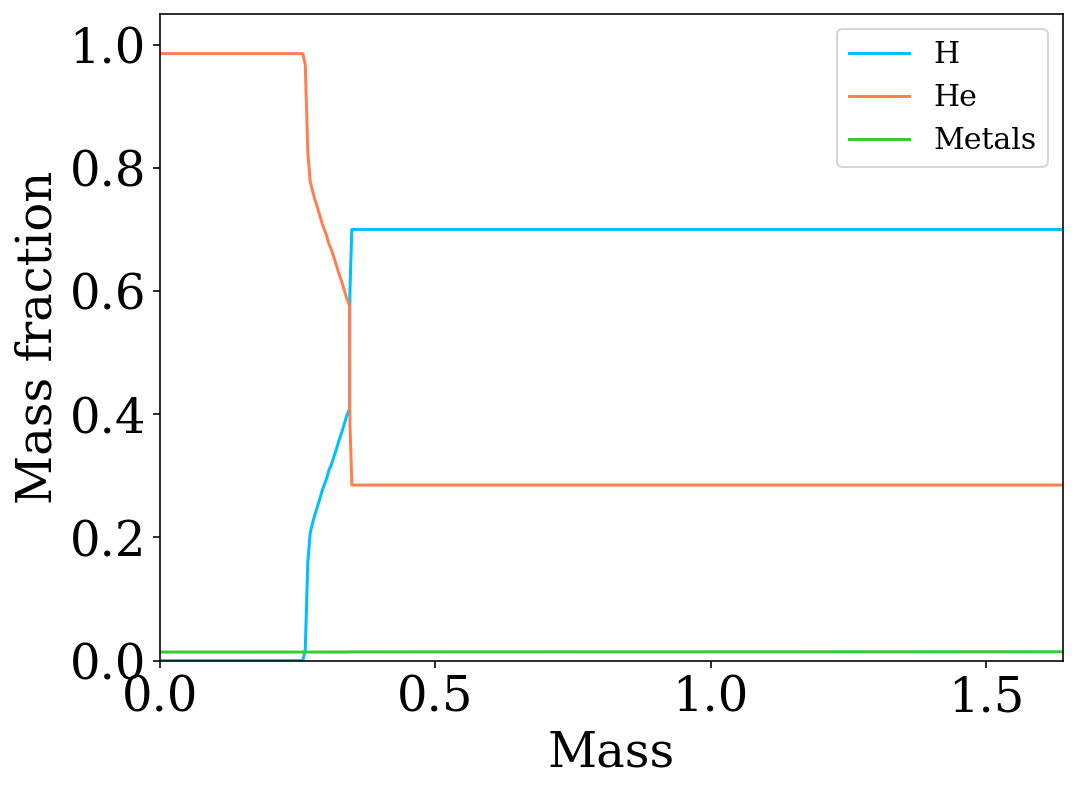

In [18]:
plt.figure(figsize=(8,6))
plt.plot(profile_2['mass'], profile_2['x_mass_fraction_H'], c='deepskyblue', ls='-', label='H')
plt.plot(profile_2['mass'], profile_2['y_mass_fraction_He'], c='coral', ls='-', label='He')
plt.plot(profile_2['mass'], profile_2['z_mass_fraction_metals'], c='limegreen', ls='-', label='Metals')

plt.xlim(0, np.max(profile_2['mass']))
plt.ylim(0, 1.05)

plt.xlabel('Mass')
plt.ylabel('Mass fraction')

plt.legend(fontsize=15)

plt.tight_layout()

# plt.show()

# plt.savefig("Plots/f2f_Default_AGB.png",dpi=300,bbox_inches='tight')

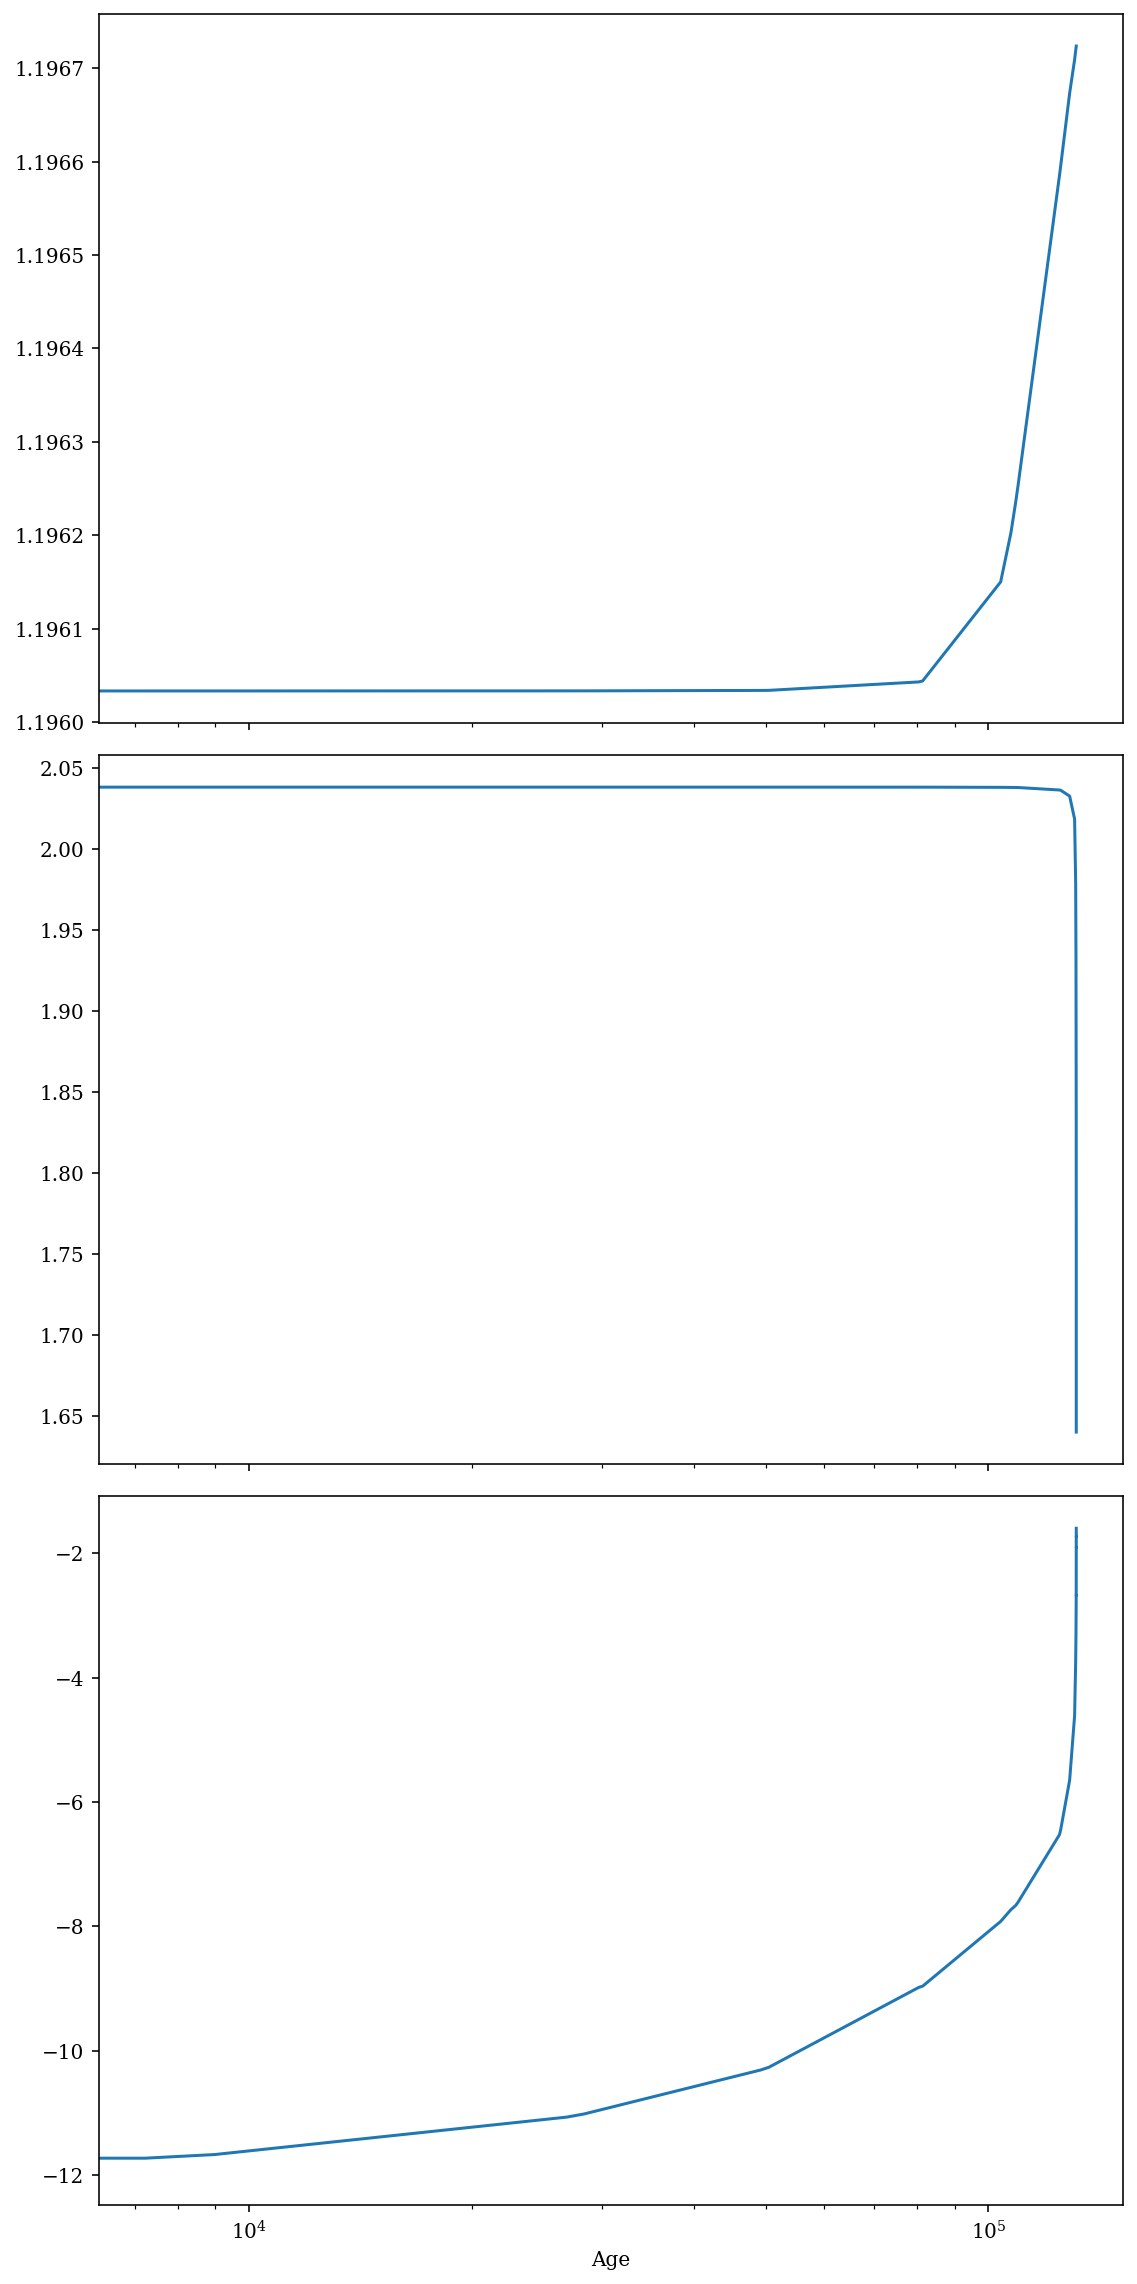

In [6]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 16), sharex=True)
axs[0].plot(history_2['age'], history_2['star_2_mass'])
axs[1].plot(history_2['age'], history_2['star_1_mass'])
axs[2].plot(history_2['age'], history_2['lg_mtransfer_rate'])

axs[2].set_xscale('log')
axs[2].set_xlabel('Age')
fig.tight_layout()

# Visualization

working
True


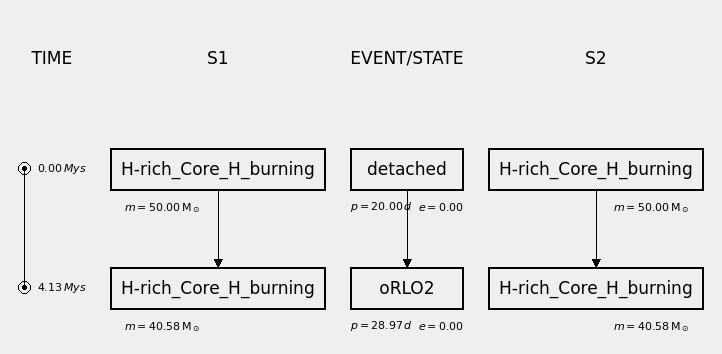

True


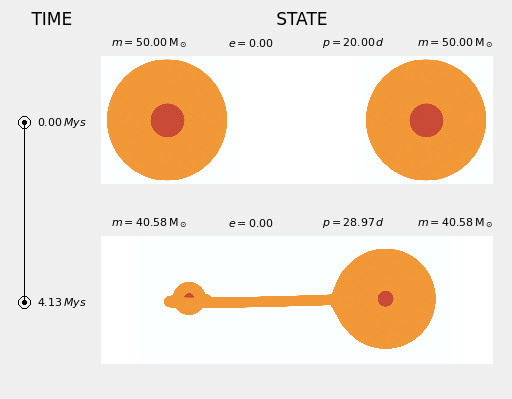

In [13]:
from PyQt5.QtWidgets import QApplication, QMainWindow
print('working')

from posydon.visualization.VHdiagram import VHdiagram, DisplayMode
from posydon.visualization.VH_diagram.PresenterMode import PresenterMode

VHdiagram('binary.h5', index=0, binary=True, presentMode=PresenterMode.DETAILED, displayMode=DisplayMode.INLINE_B)
VHdiagram('binary.h5', index=0, binary=True, presentMode=PresenterMode.DIAGRAM, displayMode=DisplayMode.INLINE_B)

In [ ]:
from posydon.visualization.VHdiagram import VHdiagram
from posydon.visualization.VH_diagram.PresenterMode import PresenterMode

VHdiagram('population.h5', index=1, presentMode=PresenterMode.DIAGRAM)

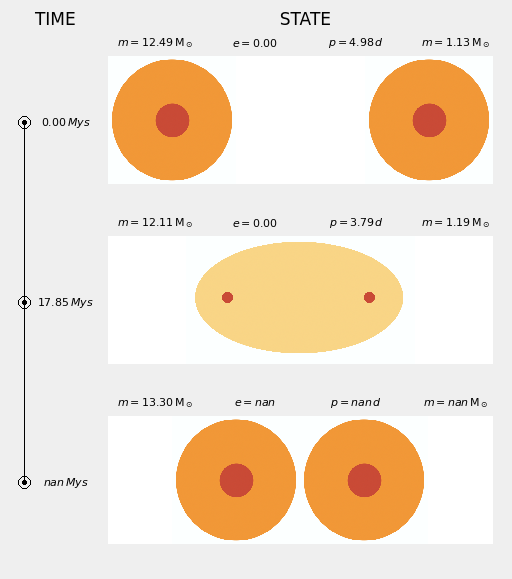

In [80]:
from posydon.visualization.VHdiagram import VHdiagram, DisplayMode
from posydon.visualization.VH_diagram.Presenter import PresenterMode

VHdiagram(
    "population.h5",
    index=30,
    presentMode=PresenterMode.DIAGRAM,
    displayMode=DisplayMode.INLINE_B)